Pyro
====


**Pyro** is a **probabilistic programming language** released by Uber AI Labs. It is a tool for deep probabilistic modelling built on top of PyTorch, unifying the best of modern deep learning and Bayesian modeling. [[link]](https://eng.uber.com/pyro/)

A probabilistic programming language is a programming language designed to describe probabilistic models and then perform inference in those models.

Like PyTorch, Pyro supports arbitrary Python code (iteration, recursion, higher-order functions etc.), which makes it universal to represent any computable probability distribution. Thanks to PyTorch, Pyro can benefit from GPU-accelerated tensor math.


In [1]:
# import pytorch and pyro; set random generator seed
import torch

import pyro
import pyro.distributions as dist

pyro.set_rng_seed(101)

# to clear all variables stored by Pyro
pyro.clear_param_store()

# enable validation for useful warnings and errors
pyro.enable_validation(True)


----

## Primitive Stochastic Functions

The key element of probabilistic programs are primitive stochastic functions, or distributions. Currently, Pyro uses PyTorch distributions: `torch.distributions`.


In [2]:
# draw a sample from N(0, 1)
loc = 0.  # mean
scale = 1.  # variance
normal_dist = torch.distributions.Normal(loc, scale)  # normal distribution N(0, 1)
x = normal_dist.rsample()  # draw a sample - for N rsample
print(f"normal | sample: {x}")


normal | sample: -1.3905061483383179


In [3]:
# draw a sample from B(alpha=2, beta=5)
alpha = 2
beta = 5
beta_dist = torch.distributions.Beta(alpha, beta)
x = beta_dist.sample()
print(f"beta | sample: {x}")


beta | sample: 0.16051988303661346


### Model

In Pyro, models are Python functions, which take data as input and use Pyro primitives to analyze the data. All probabilistic programs are built with primitive stochastic functions and deterministic computation.

For example, suppose we would like to model daily mean temperatures and cloud cover and how their interact with each other.

Let's declare a function that will describe those interactions:
  *  define a random variable `cloudy`, given by a draw from the Bernoulli distribution with param `0.3`; this will return either `0` or `1`, so then we parse it to a string; according to this line, 30% of the time it's cloudy, 70% it's sunny
  *  define parameters of temperature distributions, i.e. mean and variance, for both cloudy and sunny weather: when it's sunny the mean is 18 degrees Celsius, with variance of 15 degrees, and when it's cloudy the mean equals 13 degrees with variance 15 degrees.
  *  use the values to declare a Normal distribution $\mathcal{N}(\mu, \sigma^2)$ and draw a sample
  *  return the weather and temperature


In [4]:
def weather():
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 13.0, 'sunny': 18.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()
    

for _ in range(3):
    print(weather())


('sunny', 34.110050201416016)
('sunny', 35.53456115722656)
('sunny', 34.380645751953125)


This function is independent of Pyro - it calls PyTorch `torch.distributions`. For a Pyro program we need to apply a few modifications.


### `pyro.sample`

It is a Pyro primitive for a latent random variable. To use `pyro.sample` we need to introduce `pyro.distributions`, which is a thin wrapper for `torch.distributions`, and `pyro.sample`, which replaces all calls of `.sample()` and `.rsample()`.


In [5]:
# draw a sample from N(0, 1)
loc = 0.  # mean
scale = 1.  # variance
x = pyro.sample("normal_sample", pyro.distributions.Normal(loc, scale))
print(f"normal | sample: {x}")


normal | sample: 3.179267168045044


In [6]:
# draw a sample from B(alpha=2, beta=5)
alpha = 2
beta = 5
x = pyro.sample("beta_sample", pyro.distributions.Beta(alpha, beta))
print(f"beta | sample: {x}")


beta | sample: 0.10001221299171448


The crucial difference here is that each sample is **named**. The backend of Pyro uses this names to uniquely identify sample statements and change their behavior at runtime, depending on how the enclosing stochastic function is used. This is how Pyro can implement various manipulations, that underlie inference algorithms.

Here, we use a short name `dist` for `pyro.distributions`.


In [7]:
# weather model rewritten as a Pyro program
def weather():
    cloudy = pyro.sample("cloudy", dist.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 13.0, 'sunny': 18.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample("temp", dist.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()


for _ in range(3):
    print(weather())


('sunny', 44.10396957397461)
('sunny', -0.5892314910888672)
('sunny', 0.5812034606933594)


Here, `weather()` is still a non-deterministic Python callable, that returns two random samples, but now invoked with `pyro.sample` - because of that Pyro allows us to access joint probability distribution over two named random variables: `cloudy` and `temp`, defining a probabilistic model that we can reason about using the techniques of probabilistic theory.

A natural further step is to build off of the model. For example, ice cream sales depend heavily on the weather. Let's define a situation, where the expected sales depend on the cloudiness and the temperature.


In [8]:
# define ice cream sales as depending on the weather
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == "sunny" and temp > 20.0 else 50.
    ice_cream = pyro.sample("ice_cream", dist.Normal(expected_sales, 10.0))
    return ice_cream

for _ in range(3):
    print(ice_cream_sales())


tensor(199.1964)
tensor(58.9899)
tensor(50.0545)


Since Pyro is embedded in Python, stochastic functions can contain complex deterministic Python - randomness can freely affect control flow! For example, recursive functions could be terminated nondeterministically, provided that we take care to use unique names of `pyro.sample`, such as in this geometric distribution counting the number of failures until the first success. Note, that each `pyro.sample` is created dynamically - we can have different numbers of named random variables.


In [9]:
# count number of drawing from Bernoulli distribution until success
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample(f"x_{t}", dist.Bernoulli(p))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t + 1)

print(geometric(0.1))


2


We might also define stochastic functions that accept as input or produce as output other stochastic functions. Here, `normal_product` returns a product of two variables sampled from normal distribution of the same parameters, whereas `make_normal_normal` returns a product of two samples from a normal distribution, where the mean is sampled from $\mathcal{N}(0, 1)$.


In [10]:
def normal_product(loc, scale):
    z1 = pyro.sample("z1", dist.Normal(loc, scale))
    z2 = pyro.sample("z2", dist.Normal(loc, scale))
    y = z1 * z2
    return y

def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", dist.Normal(0, 1))
    fn = lambda scale: normal_product(mu_latent, scale)
    return fn


print(make_normal_normal()(1.))


tensor(2.0615)


Excercise
---------


1. Create a Pyro model of flipping a coin, using Bernoulli distribution. The function a `pyro.sample`, which will be used in the loop:


In [11]:
def flip_coin():
    side = pyro.sample("side", dist.Bernoulli(0.5))
    return side

for _ in range(3):
    print("heads" if flip_coin() == 1 else "tails")


heads
tails
heads


2. Create a Pyro model for how much a person works (hourly employee). Default mean = 8, variance = 1. Take into account the following factors:
  *  being sick (decreases the number of hours in a day to 0)
  *  unexpected event (decreases the number of hours by 2)
  *  feeling lazy (leave work one hour earlier)
  *  working overtime (stay two hours longer)
  
  Use Categorical distribution. Assume your own probabilities.


In [12]:
def working_hours():
    mean = 8
    variance = 1
    # [sick, unexpected, lazy, overtime, normal]
    probas = torch.tensor([0.1, 0.05, 0.2, 0.15, 0.5])
    factor = pyro.sample("factor", dist.Categorical(probas))
    hours = pyro.sample("working_hours", dist.Normal(mean, variance))
    diff = [-hours, -2, -1, 2, 0]
    return hours + diff[factor.item()]


for _ in range(3):
    print(working_hours())

tensor(0.)
tensor(10.6948)
tensor(9.8717)


----

## Introduction to inference

In pyro, the model function can be used for approximate inference. Here, we will prepare another simple example and use it for inference.

For example, imagine driving a car with an inaccurate speedometer, that gives different values ever, let's say, with a variance of 5.0. We could try to guess the speed based on how the surroundings move and use this guess to compensate for the inaccuracy of the speedometer, however our guess is inaccurate as well. This is shown by this model:

$$speed \mid guess \sim \mathcal{N}(guess, 10)$$
$$measurement \mid guess, speed \sim \mathcal{N}(speed, 5)$$


In [13]:
def speedometer(guess):
    speed = pyro.sample("speed", dist.Normal(guess, 2.))
    return pyro.sample("measurement", dist.Normal(speed, 1.))


for i in range(5):
    print(speedometer(40))


tensor(41.5283)
tensor(39.3993)
tensor(39.7645)
tensor(41.1400)
tensor(39.5311)


### Conditioning

The utility of probabilistic programming is the ability to **condition** the generative models (such as the `speedometer`) on observed data and infer the latent factors, that might have produced the data.

In Pyro, the expression of condition is separated from evaluation via inference, so that we can write a model once and condition it on many different observations. We can constrain a model's internal `sample` statements to be equal to a given set of observations.

Considering our `speedometer`, we want to sample from the distribution of `speed` given input `guess = 40`; we are trying to infer the distribution

$$\left(speed \mid guess, measurement = 40\right) \sim ?$$

That's where `pyro.condition` comes handy. It allows us to constrain the values of sample statements. In other words, `pyro.condition` means to force the sample to return the provided value. It is a higher-order function that takes a model and a dictionary of observations and returns a new model, that has the same input and output signatures, but always uses the given value at observed `sample` statements. For example:


In [14]:
conditioned_speedometer = pyro.condition(speedometer, data={"measurement": torch.tensor(40.)})


Conditioned model behaves like an ordinary Python function - it might be parametrized as below:


In [15]:
def deferred_conditioned_speedometer(measurement, guess):
    return pyro.condition(speedometer, data={"measurement": measurement})(guess)

lambda measurement, guess: pyro.condition(speedometer, data={"measurement": measurement})(guess)

print(deferred_conditioned_speedometer(40, 100))


40


Instead of using `python.condition` we might also add the optional `obs` argument to `pyro.sample`. `obs` keyword is exclusive to the model.


In [16]:
# same as conditioned_speedometer
def speedometer(guess):
    speed = pyro.sample("speed", dist.Normal(guess, 10.))
    # condition on measurement
    return pyro.sample("measurement", dist.Normal(speed, 5.), obs=40.)


print(speedometer(45))


40.0


/Users/piotrz/.miniconda3/envs/puma/lib/python3.7/site-packages/pyro/primitives.py:86: RuntimeWarning: trying to observe a value outside of inference at measurement
  RuntimeWarning)


### Guide functions

Go back to `conditioned_speedometer`. With conditioning on an observation of `measurement` we are now able to use Pyro's approximate inference algorithm to estimate the distribution over `speed` given `guess` and `measurement == data`.

That's where *guide functions* come in use. In Pyro, the model function can be treated as the real *posterior distribution* $P(speed \mid guess, measurement)$ (given the `guess` and `measurement`, what is the probability distribution over `speed`), whereas guide is the approximation of the posterior distribution $Q(speed)$ (approximation of probability distribution over the latent variables) - the closest possible to `P`.

In practice, $Q$ will be a simpler distribution than $P$, and in Pyro guide tries to approximate the model as good as it's possible.

![image.png](https://miro.medium.com/max/800/1*cUMrUSWmLClDfYa9LTO8KA.png)

There are two criterias for guide functions to be a valid approximations for a particular model:

  *  all unobserved (i.e. not conditioned) sample statements that appear in the model must appear in the guide
  *  the guide must have the same input signature as the model (i.e. take the same arguments)
  
The precise meaning of the guide is different across different inference algorithms (in Pyro importance sampling, MCMC and stochastic variational inference are available).

In the case of our `speedometer`, the true posterior distribution is actually tractable and could be determined analytically, however, such case is rather an exception than the rule. For example, in a case of a nonlinearity in the model the posterior may become intractable:


In [17]:
def nonlinear_function(value):
    if value >= 10:
        return 0.01 * value ** 2 +  value
    else:
        return abs(0.02 * value ** 2 + 0.8 * value)

def intractable_speedometer(guess):
    speed = pyro.sample("speed", dist.Normal(guess, 10.))
    return pyro.sample("measurement", dist.Normal(nonlinear_function(speed), 5))
    
intractable_speedometer(38)


tensor(15.8543)

In such case we should use a top-level function `python.param`. It specifies a *family* of guides indexed by named parameters, and searches for the member of that family that is the best approximation according to some loss functions. This approach to approximate posterior is called ***variational inference***.

`pyro.param` is exclusive to guides. It is a frontend for Pyro's key-value *parameter store*. Like `pyro.sample`, it is always called with a name as its first argument.

The first time `pyro.param` is called with a particular name, its argument is stored in the parameter store and the value is returned. After that, whent it's called with that name, it returns the value from the parameter store regardless of any other argument. Furthermore, `pyro.param` provides differentiation for the inputs - this are the pieces of the guide that are actually going to be trained.

For example, we could parametrize normal distribution in `speedometer_guide` as below:


In [18]:
def speedometer_parametrized_guide(guess):  # same argument set as the model
    loc = pyro.param("loc", torch.tensor(guess))
    scale = pyro.param("scale", torch.tensor(1.))
    return pyro.sample("speed", dist.Normal(loc, torch.abs(scale)))  # notice absolute value of scale


Notice, that since variance of normal distribution has to be positive, we applied `torch.abs`. There are other restrictions that might be necessary in other distributions. PyTorch distributions library includes a module containing such restrictions: [torch.distributions.constraints](https://pytorch.org/docs/master/distributions.html#module-torch.distributions.constraints). Applying a constrinat is done by passing the relevant object to `pyro.param` as below:


In [19]:
from torch.distributions import constraints


def speedometer_parametrized_guide_constrained(guess):
    loc = pyro.param("loc", torch.tensor(guess))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("speed", dist.Normal(loc, scale))


### Stochastic variational inference

In Pyro, the main algorithm of variational inference is stochastic variational inference. It has three key characteristics:
  *  parameters are real-valued tensors
  *  estimates of a loss function are computed using Monte Carlo estimates from samples of execution histories of the model and guide
  *  to search for optimal parameters, stochastic gradient descent is used

Each step in the training proess will take one pass through the model and incorporate the observed data. Then, it will go through the model once again, replacing `pyro.sample` statements with corresponding statement from the guide and compare the resulting distribution from the model and the guide, to adjust the `pyro.param` values in order to get the guide closer to the model. In theory, that should cause the guide to follow the model and get close enough to approixmate it.

The difference between two probability distribution is commonly quantified using the KL divergence:

$$D_{KL}\left(guide \mid\mid model\right) = -\sum_{x \in \mathcal{X}} Q_{guide}\left(x\right) \left(\log P_{model}\left(x \mid z\right) - \log Q_{guide}\left(x\right)\right)$$
$$=-\mathbb{E}_{x \sim Q_{guide}} \left[\log P_{model}\left(x \mid z\right) - \log Q_{guide}\left(x\right)\right]$$

> For all possible values of the latent variable(s) $x$, compute the difference in log probability between the model and the guide, and weigh that difference by the likelihood of each assignment under the guide (expectation of the difference in terms of the guide)

This still requires us to know $P_model{z}$, which is usually intractable. Instead, we can factor out the intractable term to get ELBO (*Evidence Lower BOund*):

$$ELBO\left(guide \mid model\right) = \mathbb{E}_{x \sim Q_{guide}} \left[\log P_{model}\left(x, z\right) - \log Q_{guide}\left(x\right)\right]$$

The crucial difference is, that here $P_{model}$ is a joint probability and therefore might be computed directly in the code.

Our goal is to use the ELBO to determine how different the guide function is from the conditioned model.



loc   = 40.22404098510742
scale = 0.8617172241210938


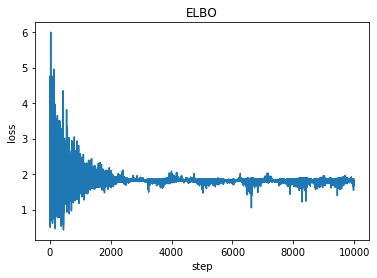

In [25]:
import matplotlib.pyplot as plt
from tqdm.notebook import trange


guess = 41.

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_speedometer,
                     guide=speedometer_parametrized_guide_constrained,
                     optim=pyro.optim.SGD({"lr": 1e-3}),
                     loss=pyro.infer.Trace_ELBO())

losses, locs, scales = [], [], []
n_steps = 10000
for t in trange(n_steps):
    losses.append(svi.step(guess))
    locs.append(pyro.param("loc").item())
    scales.append(pyro.param("scale").item())
    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
print(f"loc   = {pyro.param('loc').item()}")
print(f"scale = {pyro.param('scale').item()}")


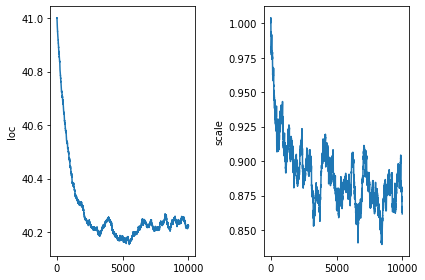

In [26]:
plt.subplot(1,2,1)
plt.plot(locs)
plt.ylabel('loc')

plt.subplot(1,2,2)
plt.ylabel('scale')
plt.plot(scales)
plt.tight_layout()

Notice, that we will load the parameter values from the parameter store - that's where Pyro stores them throughout training.
